<a href="https://colab.research.google.com/github/LollaGavrishko/ML/blob/main/Dogs_vs_Cats_Kaggle_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Источник
В основе этого блокнота
Kernel "Keras CNN Dog or Cat Classification" by Uysim

https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

#Необходимые ресурсы

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
import random
import os
import zipfile
import io, shutil

#Загружаем токен аутентификации

In [ ]:
file = files.upload()

Saving kaggle.json to kaggle.json


#Копируем токен в каталог .kaggle

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

#Загружаем данные с сайта Kaggle

In [ ]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 99% 808M/814M [00:06<00:00, 139MB/s]
100% 814M/814M [00:06<00:00, 141MB/s]


In [ ]:
!ls

dogs-vs-cats-redux-kernels-edition.zip	sample_data


In [ ]:
!unzip dogs-vs-cats-redux-kernels-edition.zip

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [ ]:
!ls

dogs-vs-cats-redux-kernels-edition.zip	sample_submission.csv  train.zip
sample_data				test.zip


In [ ]:
!head sample_submission.csv

id,label
1,0.5
2,0.5
3,0.5
4,0.5
5,0.5
6,0.5
7,0.5
8,0.5
9,0.5


In [ ]:
!unzip train.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/d

In [ ]:
!unzip test.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: test/5499.jpg           
  inflating: test/55.jpg             
  inflating: test/550.jpg            
  inflating: test/5500.jpg           
  inflating: test/5501.jpg           
  inflating: test/5502.jpg           
  inflating: test/5503.jpg           
  inflating: test/5504.jpg           
  inflating: test/5505.jpg           
  inflating: test/5506.jpg           
  inflating: test/5507.jpg           
  inflating: test/5508.jpg           
  inflating: test/5509.jpg           
  inflating: test/551.jpg            
  inflating: test/5510.jpg           
  inflating: test/5511.jpg           
  inflating: test/5512.jpg           
  inflating: test/5513.jpg           
  inflating: test/5514.jpg           
  inflating: test/5515.jpg           
  inflating: test/5516.jpg           
  inflating: test/5517.jpg           
  inflating: test/5518.jpg           
  inflating: test/5519.jpg           
  inflating: test/55

In [ ]:
# подсчитаем количество файлов в датасете train
!find /content/train -type f| wc -l

25000


In [ ]:
# подсчитаем количество файлов в датасете test1
!find /content/test1 -type f| wc -l

find: ‘/content/test1’: No such file or directory
0


#Разметка обучающей выборки
1 = dog, 0 = cat

In [ ]:
filenames = os.listdir("/content/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if 'cat' in category:
        categories.append(0)
    else:
        categories.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'label': categories
})

In [ ]:
# посмотрим на первые 5 записей
df.head()

,filename,label
0,cat.6534.jpg,0
1,cat.1431.jpg,0
2,cat.2233.jpg,0
3,dog.5920.jpg,1
4,dog.6674.jpg,1


In [ ]:
# общая информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  25000 non-null  object
 1   label     25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


#Определим константы

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

#Посмотрим на распределение изображений

<Axes: >

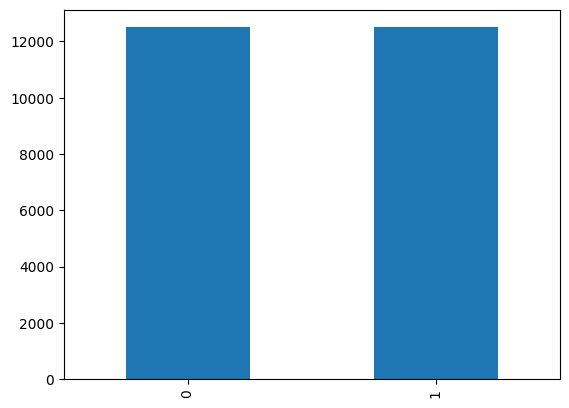

In [ ]:
df['label'].value_counts().plot.bar()

#Посмотрим на случайное изображение из датасета

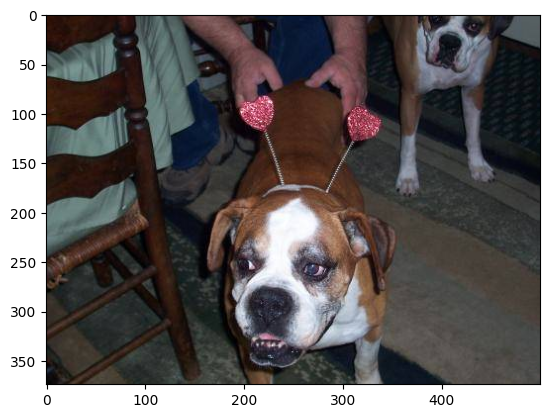

In [ ]:
sample = random.choice(filenames)
image = load_img("/content/train/" + sample)
plt.imshow(image)

#Построение модели

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras import Sequential

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',
                 input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 класса - собаки, кошки

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

#Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

#Early Stop

In [ ]:
earlystop = EarlyStopping(patience=5)

#Learning Rate Reduction
Будем уменьшать скорость обучения, если точность за 2 эпохи не увеличится.

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=2,
                                            factor=0.5,
                                            min_lr=0.00001)

#ModelCheckpoint
Будем сохранять лучший результат модели

In [ ]:
modelCheckpoint = ModelCheckpoint("model-cnn.h5",
                                  monitor='val_accuracy',
                                  verbose=2,
                                  save_best_only=True)

In [ ]:
callbacks = [earlystop, learning_rate_reduction, modelCheckpoint]

#Подготовка данных
Так как мы будем использовать image generator с class_mode = "categorical", нам нужно преобразовать категорию столбца в тип объекта - строка.

Затем imagenerator преобразует строки в one-hot encoding для решения задачи классификации.

Таким образом, мы будем конвертировать 1 в 'dog' и 0 - в 'cat'.

In [ ]:
df["label"] = df["label"].replace({0: 'cat', 1: 'dog'})

In [ ]:
# сформируем обучающую и проверочную выборку
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

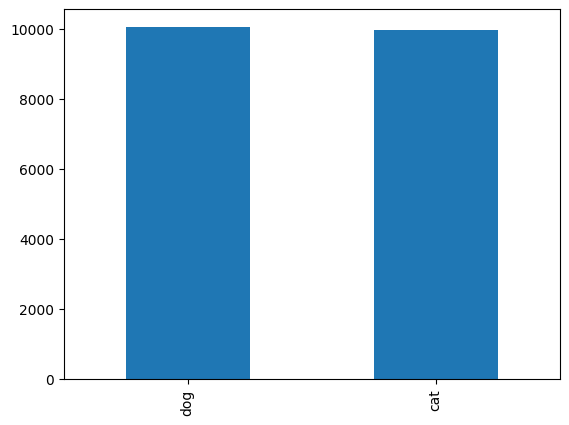

In [ ]:
# посмотрим на распределение обучающей выборки
train_df['label'].value_counts().plot.bar()

<Axes: >

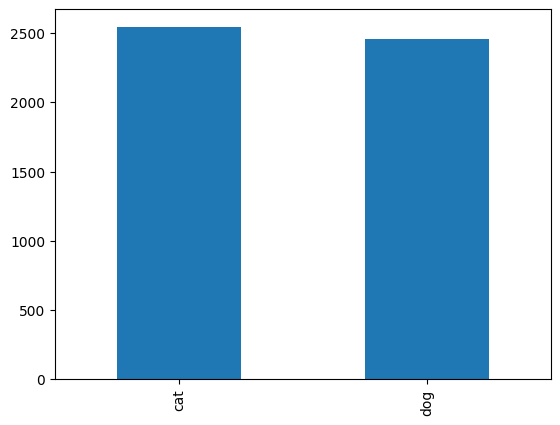

In [ ]:
# посмотрим на распределение проверочной выборки
validate_df['label'].value_counts().plot.bar()

In [ ]:
# запишем данные для обучения и проверки в переменные
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
# определим batch_size
batch_size=15

#ImageDataGenerator для обучающей и проверочной выборок

Применим ImageDataGenerator для трансформации изображений для обучающей выборки

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/train/",
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


Применим ImageDataGenerator для трансформации изображений для проверочной выборки

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/train/",
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


Посмотрим на пример трансформации изображения

In [ ]:
example_df = train_df.sample(n=2).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/train/",
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 2 validated image filenames belonging to 2 classes.


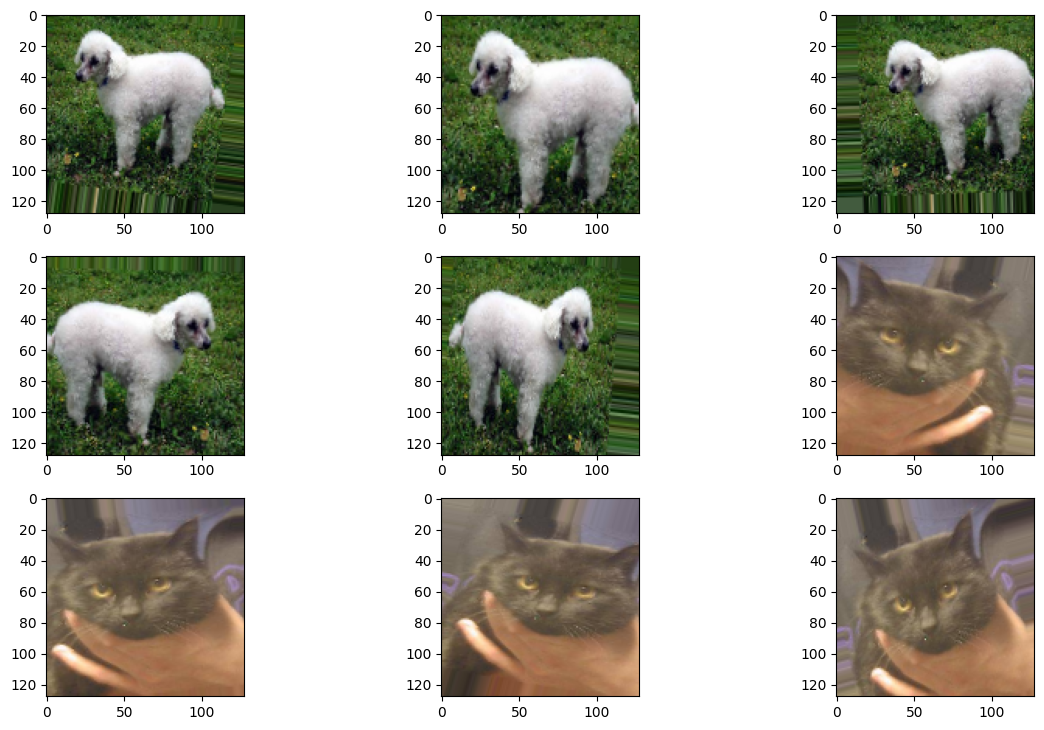

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#Обучение модели

In [ ]:
epochs=3 if FAST_RUN else 30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)


Epoch 1/30
1333/1333 [==============================] - ETA: 0s - loss: 0.7249 - accuracy: 0.6313
Epoch 1: val_accuracy improved from -inf to 0.67467, saving model to model-cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1333/1333 [==============================] - 144s 98ms/step - loss: 0.7249 - accuracy: 0.6313 - val_loss: 0.5948 - val_accuracy: 0.6747 - lr: 0.0010
Epoch 2/30
1333/1333 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.7270
Epoch 2: val_accuracy improved from 0.67467 to 0.77518, saving model to model-cnn.h5
1333/1333 [==============================] - 131s 98ms/step - loss: 0.5427 - accuracy: 0.7270 - val_loss: 0.4704 - val_accuracy: 0.7752 - lr: 0.0010
Epoch 3/30
1333/1333 [==============================] - ETA: 0s - loss: 0.4944 - accuracy: 0.7650
Epoch 3: val_accuracy did not improve from 0.77518
1333/1333 [==============================] - 144s 108ms/step - loss: 0.4944 - accuracy: 0.7650 - val_loss: 0.5200 - val_accuracy: 0.7710 - lr: 0.0010
Epoch 4/30
1333/1333 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.7896
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_accuracy did not improve from 0.

990 s / 60 = 16.5 min * 30 = 495 min = 8.25 h

#Загрузим веса модели из ModelCheckpoint

In [ ]:
model.load_weights("model-cnn.h5")

In [ ]:
# посмотрим на параметры данных по функции потерь и точности
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
history.history['accuracy']

[0.7428070902824402,
 0.7742306590080261,
 0.7920940518379211,
 0.8216162323951721,
 0.829972505569458,
 0.8406805396080017,
 0.8397798538208008,
 0.8472854495048523,
 0.850087583065033,
 0.8517388105392456,
 0.863197386264801,
 0.866249680519104,
 0.868401288986206,
 0.8724042773246765,
 0.873955488204956,
 0.880260169506073,
 0.8807605504989624,
 0.8811608552932739,
 0.8815111517906189,
 0.8829121589660645,
 0.8842131495475769,
 0.8858643770217896,
 0.8890167474746704,
 0.8877158164978027,
 0.8847135305404663,
 0.8855141401290894,
 0.887965977191925,
 0.8904678225517273,
 0.8873155117034912,
 0.8895171284675598]

In [ ]:
max(history.history['accuracy'])

0.8904678225517273

In [ ]:
history.history['val_accuracy']

[0.7771771550178528,
 0.7267267107963562,
 0.7559559345245361,
 0.8166165947914124,
 0.8346346616744995,
 0.8116115927696228,
 0.8670670390129089,
 0.8812812566757202,
 0.8484484553337097,
 0.8730731010437012,
 0.9013013243675232,
 0.8958958983421326,
 0.9043043255805969,
 0.8874874711036682,
 0.8954954743385315,
 0.9119119048118591,
 0.9109109044075012,
 0.9037036895751953,
 0.9155155420303345,
 0.9117116928100586,
 0.9145145416259766,
 0.9189189076423645,
 0.9203203320503235,
 0.9173173308372498,
 0.9179179072380066,
 0.9195195436477661,
 0.9165165424346924,
 0.9195195436477661,
 0.9203203320503235,
 0.9185185432434082]

In [ ]:
max(history.history['val_accuracy'][::])

0.9203203320503235

#Визуализация обучения

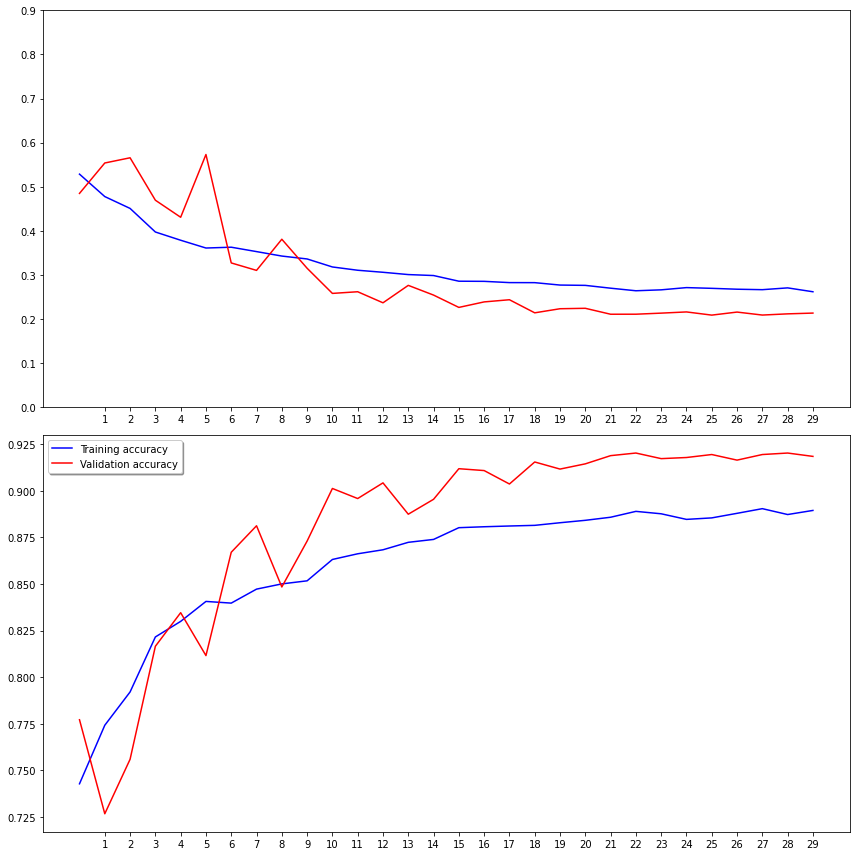

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

#Подготовка тестовой выборки

Разместим тестовые данные в DataFrame Pandas

In [ ]:
test_filenames = os.listdir("/content/test1/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_df.head()

,filename
0,1058.jpg
1,1100.jpg
2,11348.jpg
3,9830.jpg
4,4487.jpg


#ImageDataGenerator для тестовых данных

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/test1/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


#Прогноз результата
Для категориальной классификации предсказанием модели является вероятность для каждой категории, поэтому будем выбирать категорию с наибольшей вероятностью, используя функцию numpy average max

In [ ]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
predict[:3]

array([[0.03236252, 0.9676375 ],
       [0.2728205 , 0.7271795 ],
       [0.606247  , 0.393753  ]], dtype=float32)

In [ ]:
test_df['label'] = predict[:,1]

Конвертируем названия категорий в обозначения классов

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['label'] = test_df['label'].replace(label_map)
test_df['label'] = test_df['label'].replace({ 'dog': 1, 'cat': 0 })

#Визуализация тестовых данных

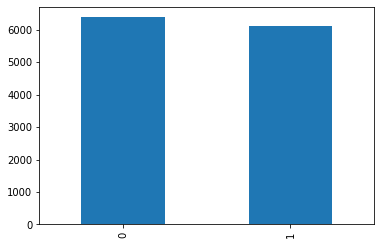

In [ ]:
test_df['label'].value_counts().plot.bar()

#Результаты предсказаний модели

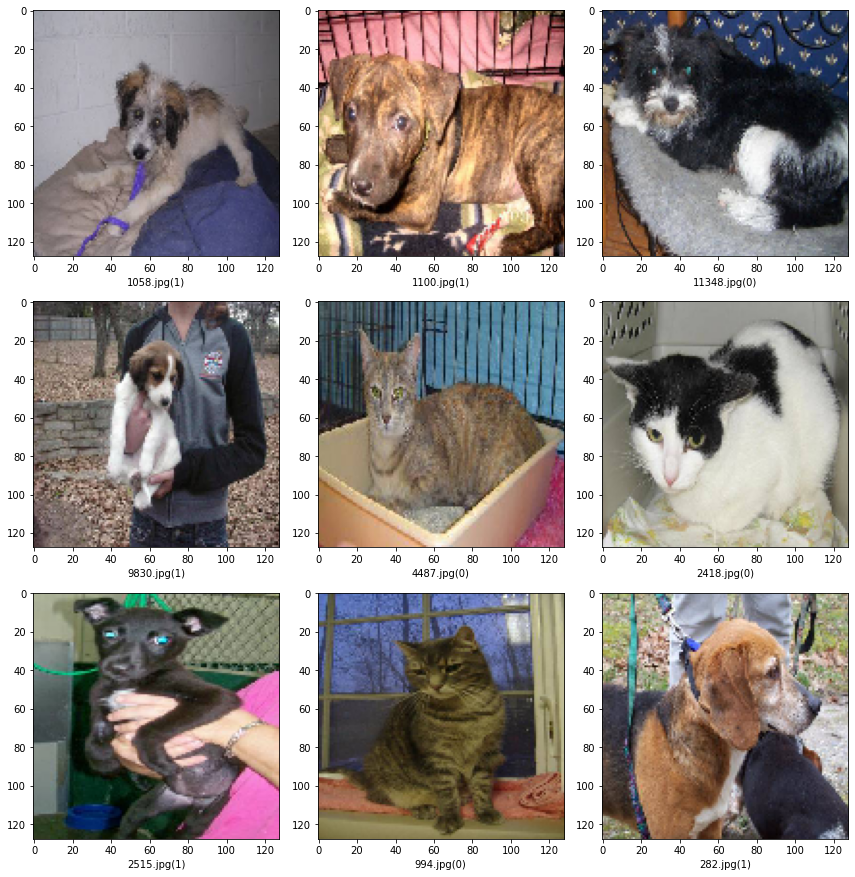

In [ ]:
sample_test = test_df.head(9)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['label']
    img = load_img("/content/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Готовим файл с решением для Kaggle

#Submission

In [ ]:
test_df.head()

,filename,label
0,1058.jpg,1
1,1100.jpg,1
2,11348.jpg,0
3,9830.jpg,1
4,4487.jpg,0


In [ ]:
submission_df = test_df.copy()

In [ ]:
submission_df.head()

,filename,label
0,1058.jpg,1
1,1100.jpg,1
2,11348.jpg,0
3,9830.jpg,1
4,4487.jpg,0


In [ ]:
submission_df['id'] = submission_df['filename'].str.split('.').str[0]

In [ ]:
submission_df.head()

,filename,label,id
0,1058.jpg,1,1058
1,1100.jpg,1,1100
2,11348.jpg,0,11348
3,9830.jpg,1,9830
4,4487.jpg,0,4487


In [ ]:
id=submission_df['id']

In [ ]:
id

0         1058
1         1100
2        11348
3         9830
4         4487
         ...  
12495     4798
12496     4517
12497     6337
12498     3079
12499     4804
Name: id, Length: 12500, dtype: object

In [ ]:
submission_df.drop(labels=['id'], axis=1,inplace = True)
submission_df.insert(0, 'id', id)

In [ ]:
submission_df.head()

,id,filename,label
0,1058,1058.jpg,1
1,1100,1100.jpg,1
2,11348,11348.jpg,0
3,9830,9830.jpg,1
4,4487,4487.jpg,0


In [ ]:
submission_df.drop(['filename'], axis=1, inplace=True)

In [ ]:
submission_df.head()

,id,label
0,1058,1
1,1100,1
2,11348,0
3,9830,1
4,4487,0


In [ ]:
submission_df.to_csv('submission.csv', index=False)

In [ ]:
!head submission.csv

id,label
1058,1
1100,1
11348,0
9830,1
4487,0
2418,0
2515,1
994,0
282,1


# Отправляем решение на соревнование

In [ ]:
!kaggle competitions submit -c dogs-vs-cats -m "Submition from Colab" -f submission.csv

100% 86.8k/86.8k [00:01<00:00, 51.7kB/s]
Could not find competition - please verify that you entered the correct competition ID and that the competition is still accepting submissions.
